#lightweight version
- Only the best config for each class
- Half of the data (train & test)
- Higher learning rate & few epochs

In [39]:
import sys

In [2]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder IFT6759 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  import load_creator
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET
  import convGRU

else:

  import models.SUNSET as SUNSET
  import models.convGRU as convGRU
  import functions.utils as utils
  import functions.load_creator as load_creator

Mounted at /content/gdrive


In [3]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import shutil
import warnings

In [4]:
# Create device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# set Random seed

seed = 10
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "models")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')

In [24]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
images_trainval = np.transpose(images_trainval, (0,3,1,2))
datetimes_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
images_test = np.transpose(images_test, (0,3,1,2))
datetimes_test = np.load(datetime_test_path, allow_pickle=True)# get weather classification

# train
w_class_train_path = os.path.join(data_folder,'train_label_3_classes_d.csv')
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'Sunny')[0].tolist()
index_train_cloudy = np.where(w_class_train == 'Cloudy')[0].tolist()
index_train_overcast = np.where(w_class_train == 'Overcast')[0].tolist() 

#test
w_class_test_path = os.path.join(data_folder,'test_label_3_classes_d.csv')
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'Sunny')[0].tolist()
index_test_cloudy = np.where(w_class_test == 'Cloudy')[0].tolist()
index_test_overcast = np.where(w_class_test == 'Overcast')[0].tolist()

In [8]:
np.shape(index_test_sunny), np.shape(index_test_cloudy), np.shape(index_test_overcast)

((5926,), (2941,), (1043,))

# Take 1/2 of the data for lightweight version

In [25]:
from random import shuffle
shuffle(index_test_sunny)
shuffle(index_test_cloudy)
shuffle(index_test_overcast)
shuffle(index_train_sunny)
shuffle(index_train_cloudy)
shuffle(index_train_overcast)

s = np.shape(index_test_sunny)[0]
c = np.shape(index_test_cloudy)[0]
o = np.shape(index_test_overcast)[0]

index_test_sunny = index_test_sunny[0:int(s*0.5)]
index_test_cloudy = index_test_cloudy[0:int(c*0.5)]
index_test_overcast = index_test_overcast[0:int(o*0.5)]

s = np.shape(index_train_sunny)[0]
c = np.shape(index_train_cloudy)[0]
o = np.shape(index_train_overcast)[0]

index_train_sunny = index_train_sunny[0:int(s*0.5)]
index_train_cloudy = index_train_cloudy[0:int(c*0.5)]
index_train_overcast = index_train_overcast[0:int(o*0.5)]

In [26]:
#Sunny

pv_log_trainval_sunny = pv_log_trainval[index_train_sunny] 
images_trainval_sunny = images_trainval[index_train_sunny]
datetimes_trainval_sunny = datetimes_trainval[index_train_sunny]

pv_log_test_sunny = pv_log_test[index_test_sunny]
images_test_sunny = images_test[index_test_sunny]
datetimes_test_sunny = datetimes_test[index_test_sunny]

# cloudy

pv_log_trainval_cloudy = pv_log_trainval[index_train_cloudy] 
images_trainval_cloudy = images_trainval[index_train_cloudy]
datetimes_trainval_cloudy = datetimes_trainval[index_train_cloudy]

pv_log_test_cloudy = pv_log_test[index_test_cloudy]
images_test_cloudy = images_test[index_test_cloudy]
datetimes_test_cloudy = datetimes_test[index_test_cloudy]

# overcast

pv_log_trainval_overcast = pv_log_trainval[index_train_overcast] 
images_trainval_overcast = images_trainval[index_train_overcast]
datetimes_trainval_overcast = datetimes_trainval[index_train_overcast]

pv_log_test_overcast = pv_log_test[index_test_overcast]
images_test_overcast = images_test[index_test_overcast]
datetimes_test_overcast = datetimes_test[index_test_overcast]

In [10]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Sunny

In [30]:
seq_len = 1
num_epochs = 20
learning_rate = 5e-5
weight_decay = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_Sunny().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_sunset(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_sunset(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_sunset(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
sunny_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 8.90277920065747 valid loss: 4.3320222144139215 test loss: 4.517030320413937
epoch: 1 train loss: 3.5933868479952094 valid loss: 2.8495152030816313 test loss: 2.8898408463870973
epoch: 2 train loss: 2.7515912993816656 valid loss: 2.427481584051736 test loss: 2.4365705091779035
epoch: 3 train loss: 2.4131736528542973 valid loss: 2.172116275684957 test loss: 2.1476513271681603
epoch: 4 train loss: 2.1806869422153636 valid loss: 1.9833708834955308 test loss: 1.9460751436280235
epoch: 5 train loss: 2.000691306600594 valid loss: 1.8335273574334718 test loss: 1.7570546112604806
epoch: 6 train loss: 1.8599948656478857 valid loss: 1.7188047857524393 test loss: 1.6184150148063097
epoch: 7 train loss: 1.7472545707871174 valid loss: 1.6277414254247347 test loss: 1.523215267071101
epoch: 8 train loss: 1.6603058872940968 valid loss: 1.5667166750518793 test loss: 1.4387233211177803
epoch: 9 train loss: 1.5935938630367323 valid loss: 1.5091014627846473 test loss: 1.42260943455478

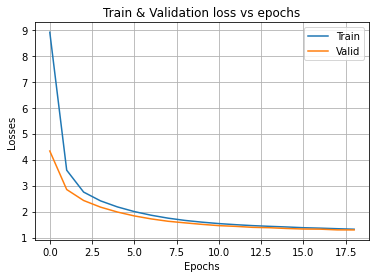

In [31]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Cloudy

In [32]:
num_epochs = 20
learning_rate = 5e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_Cloudy().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_sunset(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_sunset(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_sunset(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 9.246938272863206 valid loss: 7.033221085469712 test loss: 8.32715745727323
epoch: 1 train loss: 5.828329614210103 valid loss: 5.437008797552936 test loss: 6.624790650557122
epoch: 2 train loss: 4.841508394293901 valid loss: 4.693412873268639 test loss: 5.585361660996545
epoch: 3 train loss: 4.1720907472986575 valid loss: 4.1556529402299915 test loss: 4.7253157728083846
epoch: 4 train loss: 3.7408569876762887 valid loss: 3.8180795635192024 test loss: 4.222870463347042
epoch: 5 train loss: 3.4519705320631924 valid loss: 3.665175810546667 test loss: 4.028391263653632
epoch: 6 train loss: 3.2518468367007616 valid loss: 3.4614814172625925 test loss: 3.7702121835719997
epoch: 7 train loss: 3.1072709214886034 valid loss: 3.354773105756141 test loss: 3.6924445032527626
epoch: 8 train loss: 2.9872893642855285 valid loss: 3.28361056282328 test loss: 3.6636751660808535
epoch: 9 train loss: 2.8933183739094415 valid loss: 3.245462041230343 test loss: 3.6544906603921468
epoch: 

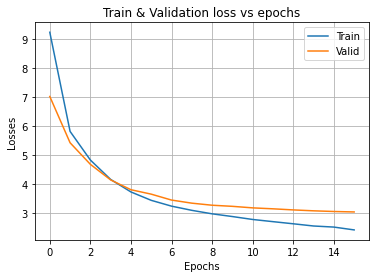

In [33]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overcast

In [34]:
num_epochs = 35
learning_rate = 5e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_Overcast().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train_sunset(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test_sunset(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test_sunset(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 3.9776598523690643 valid loss: 4.101044202558291 test loss: 3.006242046967327
epoch: 1 train loss: 2.991468308258904 valid loss: 3.3339428135570284 test loss: 2.5744751779471957
epoch: 2 train loss: 2.631278624721781 valid loss: 2.6485262532272977 test loss: 2.2550500152312316
epoch: 3 train loss: 2.371191144007918 valid loss: 2.363736863401939 test loss: 2.174668881898735
epoch: 4 train loss: 2.221023477533234 valid loss: 2.253184182997537 test loss: 2.0554292930346953
epoch: 5 train loss: 2.1071114713021704 valid loss: 2.271849496832678 test loss: 2.070824534121936
epoch: 6 train loss: 2.026485889438566 valid loss: 2.076657327818748 test loss: 1.9734584995535445
epoch: 7 train loss: 1.904553378412905 valid loss: 1.982986694280904 test loss: 1.9707599763321775
epoch: 8 train loss: 1.808819356490798 valid loss: 1.9163337526633946 test loss: 1.949409412965799
epoch: 9 train loss: 1.720123199353214 valid loss: 1.8733658664052588 test loss: 1.9621807488166598
epoch: 1

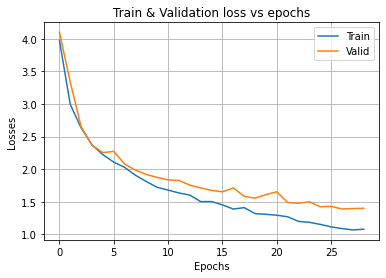

In [36]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overall Class Prediction

In [38]:
overall_loss = len(images_test_sunny)*sunny_loss**2 + len(images_test_cloudy)*cloudy_loss**2 + len(images_test_overcast)*overcast_loss**2
overall_loss = overall_loss / (len(images_test_overcast) + len(images_test_sunny) + len(images_test_cloudy))
overall_loss = math.sqrt(overall_loss)
overall_loss

2.2772146294381335